In [1]:
train_set = '/s/carnap/b/nobackup/signal/m3x/microgestures/data/train.csv'
test_set = '/s/carnap/b/nobackup/signal/m3x/microgestures/data/test.csv'
images = '/s/carnap/b/nobackup/signal/m3x/microgestures/data/images/'



In [2]:
import csv
import os
import cv2
from PIL import Image
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch


train_labels = pd.read_csv(train_set)


In [3]:
# checking to see if any missing/null values present

train_labels.isna().sum()

img_path               0
printer_id             0
print_id               0
has_under_extrusion    0
dtype: int64

In [6]:
def get_images_and_targets(labels_df, images_path):
    raw_labels = labels_df.values
    X, Y = [], []
    for i in tqdm(range(len(raw_labels))):
        image = torch.tensor(np.array(Image.open(images_path + raw_labels[i][0])))
        X.append(image)
        Y.append(raw_labels[i][3])

    return torch.tensor(X), torch.tensor(Y).reshpape(-1,1)


In [7]:

trainX, trainY = get_images_and_targets(train_labels, images)



100%|██████████| 81060/81060 [19:32<00:00, 69.11it/s] 


TypeError: only integer tensors of a single element can be converted to an index

NameError: name 'X' is not defined

(1, 480, 640, 3)


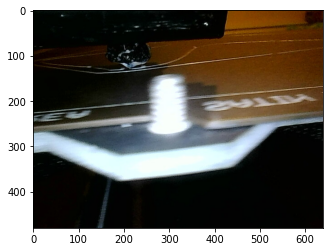

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(trainX[0])
print(trainX.shape)

In [ ]:
import numpy as np
import torch
        
class ConvNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_conv_layer, n_hiddens_per_fc_layer, n_outputs, 
                 patch_size_per_conv_layer, stride_per_conv_layer, activation_function='tanh', device='cpu'):
        
        super().__init__()
        
        self.device = device

        n_conv_layers = len(n_hiddens_per_conv_layer)
        if (len(patch_size_per_conv_layer) != n_conv_layers or
            len(stride_per_conv_layer) != n_conv_layers):
            raise Exception('The lengths of n_hiddens_per_conv_layer, patch_size_per_conv_layer, and stride_per_conv_layer must be equal.')
        
        self.activation_function = torch.tanh if activation_function == 'tanh' else torch.relu
        
        # Create all convolutional layers
        # First argument to first Conv2d is number of channels for each pixel.
        # Just 1 for our grayscale images.
        n_in = 1
        input_hw = int(np.sqrt(n_inputs))  # original input image height (=width because image assumed square)
        self.conv_layers = torch.nn.ModuleList()
        for nh, patch_size, stride in zip(n_hiddens_per_conv_layer,
                                          patch_size_per_conv_layer,
                                          stride_per_conv_layer):
            self.conv_layers.append( torch.nn.Conv2d(n_in, nh, kernel_size=patch_size, stride=stride) )
            conv_layer_output_hw = (input_hw - patch_size) // stride + 1
            input_hw = conv_layer_output_hw  # for next trip through this loop
            n_in = nh

        # Create all fully connected layers.  First must determine number of inputs to first
        # fully-connected layer that results from flattening the images coming out of the last
        # convolutional layer.
        n_in = input_hw ** 2 * n_in  # n_hiddens_per_fc_layer[0]
        self.fc_layers = torch.nn.ModuleList()
        for nh in n_hiddens_per_fc_layer:
            self.fc_layers.append( torch.nn.Linear(n_in, nh) )
            n_in = nh
        self.fc_layers.append( torch.nn.Linear(n_in, n_outputs) )
        
        self.to(self.device)


    def forward_all_outputs(self, X):
        n_samples = X.shape[0]
        Ys = [X]
        for conv_layer in self.conv_layers:
            Ys.append( self.activation_function(conv_layer(Ys[-1])) )

        for layeri, fc_layer in enumerate(self.fc_layers[:-1]):
            if layeri == 0:
                Ys.append( self.activation_function(fc_layer(Ys[-1].reshape(n_samples, -1))) )
            else:
                Ys.append( self.activation_function(fc_layer(Ys[-1])) )

        Ys.append(self.fc_layers[-1](Ys[-1]))
        return Ys


    def forward(self, X):
        Ys = self.forward_all_outputs(X)
        return Ys[-1]
    

    def train(self, X, T, batch_size, n_epochs, learning_rate, method='sgd', verbose=True):
        
        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float().to(self.device)
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).long().to(self.device)  # required for classification in pytorch
            
        X.requires_grad_(True)

        self.classes = torch.unique(T)
        
        if method == 'sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        CELoss = torch.nn.CrossEntropyLoss(reduction='mean')
        self.error_trace = []
        
        for epoch in range(n_epochs):

            num_batches = X.shape[0] // batch_size
            loss_sum = 0
            
            for k in range(num_batches):
                start = k * batch_size
                end = (k + 1) * batch_size
                X_batch = X[start:end, ...]
                T_batch = T[start:end, ...]
                
                Y = self.forward(X_batch)

                loss = CELoss(Y, T_batch)
                loss.backward()

                # Update parameters
                optimizer.step()
                optimizer.zero_grad()

                loss_sum += loss

            self.error_trace.append(loss_sum / num_batches)

            if verbose and (epoch + 1) % (n_epochs // 10) == 0:
                print(f'{method}: Epoch {epoch + 1} Loss {self.error_trace[-1]:.3f}')

        return self


    def softmax(self, Y):
        '''Apply to final layer weighted sum outputs'''
        # Trick to avoid overflow
        maxY = torch.max(Y, axis=1)[0].reshape((-1,1))
        expY = torch.exp(Y - maxY)
        denom = torch.sum(expY, axis=1).reshape((-1, 1))
        Y = expY / denom
        return Y


    def use(self, X):
        # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float().to(self.device)
        Y = self.forward(X)
        probs = self.softmax(Y)
        classes = self.classes[torch.argmax(probs, axis=1).cpu().numpy()]
        return classes.cpu().numpy(), probs.detach().cpu().numpy()


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

array([array([[[ 8, 18, 10],
               [16, 26, 18],
               [19, 29, 21],
               ...,
               [30,  0,  0],
               [26,  0,  0],
               [34,  4,  2]],

              [[ 3, 13,  5],
               [ 6, 16,  8],
               [ 6, 16,  8],
               ...,
               [35,  1,  0],
               [34,  1,  0],
               [37,  6,  1]],

              [[ 4, 14,  6],
               [ 4, 14,  6],
               [ 5, 15,  7],
               ...,
               [44,  7,  0],
               [45,  8,  0],
               [48, 11,  2]],

              ...,

              [[ 1,  3,  0],
               [ 1,  3,  0],
               [ 1,  3,  0],
               ...,
               [ 7,  1,  1],
               [ 7,  1,  1],
               [ 7,  1,  1]],

              [[ 1,  3,  0],
               [ 2,  2,  0],
               [ 2,  2,  0],
               ...,
               [ 6,  0,  0],
               [ 7,  1,  1],
               [ 7,  1,  1]],



In [ ]:
cnnet = ConvNet(28 * 28,
                [10, 20], # n_hiddens_per_conv_layer
                [5], # n_hiddens_per_fc_layer
                10,
                patch_size_per_conv_layer=[5, 7], stride_per_conv_layer=[2, 2], device=device)
cnnet.to(device)


n_epochs = 10
batch_size = 1000
learning_rate = 0.001
cnnet.train(trainX, trainY, batch_size, n_epochs, learning_rate, method='adam')

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.